In [1]:
seed_value= 0

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
import itertools
import time

In [2]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [3]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [4]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [5]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [6]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [8]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [10]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)#(batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [12]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [13]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [14]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0

In [15]:
t_warmup_steps = 4000#4000

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=t_warmup_steps):#4000
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [17]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

Text(0.5, 0, 'Train Step')

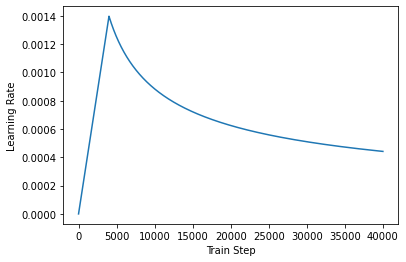

In [18]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [19]:
# print(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)).numpy()[10])

In [20]:
# import math
# print(math.sqrt(d_model)*math.sqrt(4000))

In [21]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [22]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [24]:
dp_conf = [('ain',10),('aot',10),('m',10),('din',10),('dot',10)]
# dp_conf = [('m',10)]
# dp_val_range = 255
dp_val_range = 256

def getDpList():
    l = []
    for pair in dp_conf:
        dp = pair[0]
        num = pair[1]
        for i in range(num):
            l.append(dp+str(i))

    return l

def assignOperation(allDpList):
    l = []
    for dp in allDpList:
        for num in range(dp_val_range):
#             if num<100:
#                 continue
            num_str = str(num)
            
            x = "assign "+num_str +" to "+ dp
            
            if dp[0] == 'a':
                num_str+='.0'
                
            y = dp +"="+ num_str +";"
#             print(y)
            l.append([x,y])
#             print([x,y])
  
    return l

def test():
    l = []
    for num in range(10000):
        x = list(str(num))
        y = list(x)
        y.reverse()
        l.append([x,y])
    return l

def createDict(_li):
    _max_len = len(max(_li, key=len))

    _set = sorted(set(itertools.chain.from_iterable(_li)))

    _set.remove('<START>')
    _set.remove('<END>')
    _li = list(_set)
    _li = ['<PAD>','<UNK>','<START>','<END>'] + _li
    
    _dict = {_li[i]: i for i in range(len(_li))}
    _dict_inv = {i: _li[i] for i in range(len(_li))}

    return _max_len, _dict, _dict_inv
    
def createDataSet():
    dp_list = getDpList()
    
    dataset = []

    dataset += assignOperation(dp_list)
#     dataset += test()
    
    for row in dataset:
        x_li = ['<START>']
        x_li = x_li + list(row[0])
        x_li.append('<END>')
        row[0] = x_li
        
        y_li = ['<START>']
        y_li = y_li + list(row[1])
        y_li.append('<END>')
        row[1] = y_li

#     test_dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(20000)
#     dataset += test_dataset

    X, Y = zip(*dataset)
    
    createDict(X)
    
    Tx, X_dict, X_dict_inv = createDict(X)
    Ty, Y_dict, Y_dict_inv = createDict(Y)
    
    setting = {}
    setting['Tx'] = Tx
    setting['Ty'] = Ty
    setting['X_dict'] = X_dict
    setting['Y_dict'] = Y_dict
    setting['X_dict_inv'] = X_dict_inv
    setting['Y_dict_inv'] = Y_dict_inv
    x_vocab_len = len(X_dict)
    y_vocab_len = len(Y_dict)
    setting['x_vocab_len'] = x_vocab_len
    setting['y_vocab_len'] = y_vocab_len
    
    np.save("npy/setting.npy", setting)
    
#     print(setting)
    
    encoded_x = [[X_dict[j] for j in i] for i in X]
    encoded_y = [[Y_dict[j] for j in i] for i in Y]
    
    padded_x = pad_sequences(encoded_x, padding="post")
    padded_y = pad_sequences(encoded_y, padding="post")


    shuffled_xLabel, shuffled_yLabel = shuffle(padded_x, padded_y, random_state=seed_value) #0
#     shuffled_xLabel = padded_x
#     shuffled_yLabel = padded_y

    train_XLabel, test_XLabel = np.split(shuffled_xLabel, [int(len(shuffled_xLabel)*0.9)])
    train_YLabel, test_YLabel = np.split(shuffled_yLabel, [int(len(shuffled_yLabel)*0.9)])
    
    np.save('npy/train_XLabel.npy', train_XLabel)
    np.save('npy/test_XLabel.npy', test_XLabel)
    np.save('npy/train_YLabel.npy', train_YLabel)
    np.save('npy/test_YLabel.npy', test_YLabel)
    
def loadDataSet():
    setting = np.load('npy/setting.npy',allow_pickle='TRUE').item()
    
    train_XLabel = np.load('npy/train_XLabel.npy')
    test_XLabel = np.load('npy/test_XLabel.npy')
    train_YLabel = np.load('npy/train_YLabel.npy')
    test_YLabel = np.load('npy/test_YLabel.npy')
    
    return setting, train_XLabel, test_XLabel, train_YLabel, test_YLabel

# createDataSet()
setting, train_XLabel, test_XLabel, train_YLabel, test_YLabel = loadDataSet()

Tx = setting['Tx']
Ty = setting['Ty']
X_dict = setting['X_dict']
Y_dict = setting['Y_dict']
X_dict_inv = setting['X_dict_inv']
Y_dict_inv = setting['Y_dict_inv']
x_vocab_len = setting['x_vocab_len']
y_vocab_len = setting['y_vocab_len']

print(Tx, Ty)
# print(X_dict)
# print(Y_dict)
# print(X_dict_inv)
# print(Y_dict_inv)
print(x_vocab_len, y_vocab_len)

20 13
24 24


In [25]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=x_vocab_len,#tokenizers.pt.get_vocab_size(),
    target_vocab_size=y_vocab_len,#tokenizers.en.get_vocab_size(),
    pe_input=Tx,#1000
    pe_target=Ty,#1000
    rate=dropout_rate)

In [26]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [27]:
# checkpoint_path = "./checkpoints/att_map"

# ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print('Latest checkpoint restored!!')
# # ckpt_manager.save()

In [28]:
def evaluate(sentence, max_length=Ty):
    encoder_input = tf.constant([[X_dict['<START>']]+[X_dict[j] for j in sentence]],dtype="int64")
    output = tf.constant([[2]],dtype="int64")
    end = tf.constant([[3]],dtype="int64")

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(encoder_input,output,False,
                                             enc_padding_mask,
                                             combined_mask,
                                             dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.argmax(predictions, axis=-1)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end:
            break
    
    text = [Y_dict_inv[j] for j in output.numpy()[0]]
    tokens = text
    tokens = tf.constant([tokens])

    text = list(filter(lambda x: x != '<END>' , text))
    text = list(filter(lambda x: x != '<START>' , text))

    text = ''.join(text)

    return text, tokens, attention_weights

In [45]:
def plot_attention_map(file_name = None):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    translated_text, translated_tokens, attention_weights = evaluate(sentence)

    output_text = list(translated_text)

    head = 0
    # shape: (batch=1, num_heads, seq_len_q, seq_len_k)
    attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)
    
    li = []

    for h, head in enumerate(attention_heads):
        head = np.delete(head, -1, 0)
        head = np.delete(head, 0, 1)
        li.append(head)
    
#     li_c = li[0] + li[1] + li[2] + li[3] + li[4] + li[5] + li[6] + li[7]
#     li_c = li_c/8

    comp = li[2]
    comp[8] = li[0][8]
    comp[9] = li[0][9]


    

        
#     attention = attention_heads[head]
    

    
#     attention = np.delete(attention, -1, 0)
#     attention = np.delete(attention, 0, 1)
    

    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(1, 1, 1)
    
    axData = ax.imshow(comp, cmap="viridis")
#     axData = ax.imshow(li_c, cmap="Greens")
    colorBar = fig.colorbar(axData, orientation='horizontal',shrink=0.9)
    colorBar.ax.set_xlabel('$Attention\;weights$', labelpad=2)
    
    title = "$epoch:"+"90"+"\;batch:"+"0"+"$"

    ax.set_title(title)
    
    ax.set_xticks(range(len(input_text)))
    ax.set_xticklabels(input_text, rotation=0)

    ax.set_yticks(range(len(output_text)))
    ax.set_yticklabels(output_text)

    ax.set_xlabel('$Input\;Sequence$')
    ax.set_ylabel('$Output\;Sequence$')
    
    ax.grid()
    
    if file_name:
        plt.savefig(file_name, dpi=300)
        plt.close(fig)
    
#     return fig

# plot_attention_map()

In [30]:
def plot_one_attention_head(input_text,output_text,attention):
    attention = np.delete(attention, -1, 0)
    attention = np.delete(attention, 0, 1)
    
    ax = plt.gca()
    ax.imshow(attention)

    ax.set_xticks(range(len(input_text)))
    ax.set_yticks(range(len(output_text)))


    ax.set_xticklabels(input_text)
    ax.set_yticklabels(output_text)
    ax.grid()

In [31]:
def plot_all_attention_head(file_name = None):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    translated_text, translated_tokens, attention_weights = evaluate(sentence)
    output_text = list(translated_text)
    
    
    
    attention_heads = tf.squeeze(attention_weights['decoder_layer4_block2'], 0)

    
    fig = plt.figure(figsize=(16, 6))
    
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_one_attention_head(input_text, output_text, head)

        ax.set_title(f'Head {h+1}')

    plt.tight_layout()
#     plt.show()
    
    if file_name:
        plt.savefig(file_name, dpi=300)
        plt.close(fig)
    else:
        plt.show()
# plot_all_attention_head()

In [32]:
def saveAttData(epoch,batch):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    translated_text, translated_tokens, attention_weights = evaluate(sentence)
    output_text = list(translated_text)
    name = str(epoch).zfill(5)+"_"+str(batch).zfill(5)
    np.save("att_data/npy_att/"+name+".npy", attention_weights)
    np.save("att_data/npy_outtext/"+name+".npy", output_text)

In [33]:
batch_size = 32#16#32#10#16
train_XLabel_chunks = [train_XLabel[x:x+batch_size] for x in range(0, len(train_XLabel), batch_size)]
train_YLabel_chunks = [train_YLabel[x:x+batch_size] for x in range(0, len(train_YLabel), batch_size)]

In [34]:
EPOCHS = 30

In [35]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,True,enc_padding_mask,combined_mask,dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [36]:
ten = 0

In [37]:
# for i in range(2):
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

#     batc = 0
    for train_x, train_y in zip(train_XLabel_chunks, train_YLabel_chunks):
        train_step(tf.constant(train_x,dtype="int64"), tf.constant(train_y,dtype="int64"))
#         saveAttData(epoch+ten*EPOCHS,batc)
#         batc +=1
#     plot_attention_map('attentionMap/'+str(epoch+ten*EPOCHS).zfill(4)+'_'+str(0).zfill(4)+'.png')
#     plot_all_attention_head('attentionMap/'+str(epoch+ten*EPOCHS).zfill(4)+'_'+str(0).zfill(4)+'.png')

    print(f'Epoch {epoch} Loss {train_loss.result():.16f} Accuracy {train_accuracy.result():.16f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

print(ten)
ten += 1

Epoch 0 Loss 1.3051334619522095 Accuracy 0.6306353807449341
Time taken for 1 epoch: 26.28 secs

Epoch 1 Loss 0.1198729276657104 Accuracy 0.9641000628471375
Time taken for 1 epoch: 13.30 secs

Epoch 2 Loss 0.0210913922637701 Accuracy 0.9950691461563110
Time taken for 1 epoch: 13.74 secs

Epoch 3 Loss 0.0055547920055687 Accuracy 0.9987143874168396
Time taken for 1 epoch: 14.18 secs

Epoch 4 Loss 0.0000110497840069 Accuracy 1.0000000000000000
Time taken for 1 epoch: 14.24 secs

Epoch 5 Loss 0.0000005607513458 Accuracy 1.0000000000000000
Time taken for 1 epoch: 14.15 secs

Epoch 6 Loss 0.0848685652017593 Accuracy 0.9823902845382690
Time taken for 1 epoch: 14.24 secs

Epoch 7 Loss 0.0246072262525558 Accuracy 0.9939517378807068
Time taken for 1 epoch: 14.42 secs

Epoch 8 Loss 0.0215125959366560 Accuracy 0.9952679872512817
Time taken for 1 epoch: 14.25 secs

Epoch 9 Loss 0.0423348098993301 Accuracy 0.9915018677711487
Time taken for 1 epoch: 14.09 secs

Epoch 10 Loss 0.0509577654302120 Accurac

In [38]:
# plot_all_attention_head('attentionMap/'+'_d_'+str(dropout_rate)+'_w_'+str(t_warmup_steps)+'_b_'+str(batch_size)+'_e_'+str(85)+'.png')

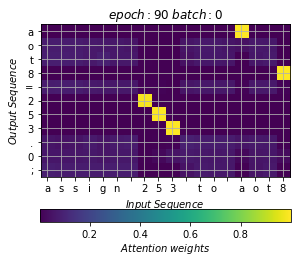

In [39]:
plot_attention_map()

In [40]:
# plot_all_attention_head()

In [41]:
# plot_all_attention_head()

In [42]:
def plot_attention_map_from_file(epoch,batch):
    sentence = "assign 253 to aot8"
    input_text = list(sentence)
    
    name = str(epoch).zfill(5)+"_"+str(batch).zfill(5)
#         setting = np.load('npy/setting.npy',allow_pickle='TRUE').item()
        
    attention_weights = np.load("att_data/npy_att/"+name+".npy",allow_pickle='TRUE').item()
    output_text = np.load("att_data/npy_outtext/"+name+".npy")
#     print(output_text)
    
    if ''.join(output_text) != "aot8=253.0;":
        return
    
#     if batch%10 != 0:
#         return
    
#     input_text = list(sentence)
#     translated_text, translated_tokens, attention_weights = evaluate(sentence)
#     output_text = list(translated_text)

    head = 0
    # shape: (batch=1, num_heads, seq_len_q, seq_len_k)
    attention_heads = tf.squeeze(
      attention_weights['decoder_layer4_block2'], 0)
    attention = attention_heads[head]
    
    attention = np.delete(attention, -1, 0)
    attention = np.delete(attention, 0, 1)
    
    fig = plt.figure(figsize=(5,4))
    ax = fig.add_subplot(1, 1, 1)
    
    axData = ax.imshow(attention, cmap="viridis")
    colorBar = fig.colorbar(axData, orientation='horizontal',shrink=0.9)
    colorBar.ax.set_xlabel('$Attention\;weights$', labelpad=2)
    
    title = "$epoch:"+"90"+"\;batch:"+"0"+"$"

    ax.set_title(title)
    
    ax.set_xticks(range(len(input_text)))
    ax.set_xticklabels(input_text, rotation=0)

    ax.set_yticks(range(len(output_text)))
    ax.set_yticklabels(output_text)

    ax.set_xlabel('$Input\;Sequence$')
    ax.set_ylabel('$Output\;Sequence$')
    
    ax.grid()
    
#     if file_name:
    plt.savefig('attentionMap/'+name+'.png', dpi=300)
    plt.close(fig)
# plot_attention_map_from_file(88,115)

In [43]:
# for i in range(30):
#     if i<16 or i>17:
#         continue
#     for j in range(720):
#         if j%10 ==0:
#             plot_attention_map_from_file(i,j)
    

In [44]:
# plot_attention_map_from_file(0,10)